In [85]:
import pandas as pd 
import numpy as np
import datetime as dt
from pandas.tseries.offsets import MonthEnd, Day, Week
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

#### Importing the data

In [86]:
prices = pd.read_csv('prices.csv', engine = 'pyarrow')
prices.index = prices.iloc[:,0]
prices.index = pd.to_datetime(prices.index)
prices = prices.iloc[:,1:]
prices = prices.astype(float)

In [87]:
ineg = pd.read_csv('Ineg.csv', engine = 'pyarrow')
ineg.index = ineg.iloc[:,0]
ineg.index = pd.to_datetime(ineg.index)
ineg = ineg.iloc[:,1:]
ineg = ineg.astype(float)

In [88]:
p_vpa = pd.read_csv("p_vpa.csv", engine = "pyarrow")
p_vpa.index = p_vpa.iloc[:,0]
p_vpa.index = pd.to_datetime(p_vpa.index)
p_vpa = p_vpa.iloc[1:,1:]
p_vpa = p_vpa.astype(float)

In [89]:
ev_ebitda = pd.read_csv('Ev_ebitda.csv', index_col = 'Data', engine = 'pyarrow')
ev_ebitda.index = pd.to_datetime(ev_ebitda.index)
ev_ebitda = ev_ebitda.astype(float)

#### Define and automatization of the model

In [90]:
class Strategy():
    """
    Funcion created to calculate
    the strategy profit for a quality
    and value intersection and posterior
    momentum filter. Retrieving the strategy profit.
   

   
    Parameters
    ----------

    Prices: `pd.Series or pd.DataFrame` --> Series of historical prices data for the stocks

    Ineg: `pd.Series or pd.DataFrame` --> Series of the negotiability index data for the stocks

    Pb: `pd.Series or pd.DataFrame` --> Series of Price / Book data for the stocks

    Ebitda: `pd.Series or pd.DataFrame` --> Series of Entreprise Value / Ebitda data for the stocks
    
    Initial_data: `DateTime` -->  The initial date for the strategy
    
    Final_data: `DateTime` -->  The final date for the strategy

    """

    def __init__(self, prices, ineg, pb, ebitda, initial_data = '2000-02-28', final_data = '2021-12-31', momentum_size:int = .3, quality_size: int = .5, position: str = 'long-only', momentum_lookback:int = 11):
        if not isinstance(prices, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Prices must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(ineg, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Ineg must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(pb, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Price to Book must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(ebitda, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Entreprise Value / Ebitda must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(initial_data, dt.datetime):
            raise ValueError("Initial Data for the analysis must be a Datetime.datetime")

        if not isinstance(final_data, dt.datetime):
            raise ValueError("Final Data must be a Datetime.datetime")

        if not isinstance(momentum_size, (int, float)):
            raise ValueError("The decile of momentum decile that gonna be taken must be a interger or float number")

        if not isinstance(quality_size, (int, float)):
            raise ValueError("The decile of Quality / Value intersection decile that gonna be taken must be a interger or float number")

        self.initial_data = pd.to_datetime(initial_data) - MonthEnd(1)
        self.final_data = pd.to_datetime(final_data) + MonthEnd(1)
        self.ineg_mtl = (ineg.resample("1M").last()).loc[self.initial_data : self.final_data]
        self.vpa_mtl = (pb.resample("1M").last()).loc[self.initial_data : self.final_data]
        self.ebitda_mtl = (ebitda.resample("1M").last()).loc[self.initial_data : self.final_data]

        self.past_11 = (prices.resample("M").last()/ prices.resample("M").last().shift(momentum_lookback) - 1)
        self.daily_prices = ((prices / prices.shift(1)) - 1).loc[self.initial_data : self.final_data]
        self.returns = ((prices.resample("M").last() / prices.resample("M").last().shift(1)) - 1).loc[self.initial_data : self.final_data] 
        
        self.past_11 = (prices.resample("M").last()/ prices.resample("M").last().shift(momentum_lookback) - 1)
        self.momentum = momentum_size
        self.quality = quality_size
        self.position = position.lower()

    def filtro(self, formation):  

        if not isinstance(formation, dt.datetime):
            raise ValueError("Formation data for the analysis must be a Datetime.datetime")
        
        end_measurement = formation - self.tipo
        universo = self.ineg_mtl.loc[end_measurement].sort_values(ascending = False).head(100).index.to_list()
        filtro_pb = self.vpa_mtl.loc[end_measurement, self.vpa_mtl.columns.isin(universo)]
        filtro_ev_ebitda = self.ebitda_mtl.loc[end_measurement, self.ebitda_mtl.columns.isin(universo)]
        filtro_ev_ebitda = filtro_ev_ebitda[filtro_ev_ebitda >= 0]
        filtro_both = pd.DataFrame({'P Vpa': filtro_pb, 'Ev Ebitda': filtro_ev_ebitda})
        filtro_both = filtro_both.replace(np.nan, '0').astype(float)
        filtro_both['PVpa filtrados'] = pd.qcut(filtro_both['P Vpa'], q = 100, labels = False, duplicates = 'drop')
        filtro_both['Ev Ebitda filtrados'] = pd.qcut(filtro_both['Ev Ebitda'], q = 100, labels = False, duplicates = 'drop')
        filtro_both = filtro_both.replace(np.nan, 0).astype(float)
        filtro_both['Filtro Final'] = filtro_both['PVpa filtrados'] + filtro_both['Ev Ebitda filtrados'] 
        filtro_both = filtro_both.replace(0, np.nan)
        filtro_both['Filtro Final'] = filtro_both['Filtro Final'].dropna()
        final_filter = filtro_both['Filtro Final'].dropna().sort_values(ascending = False)

        pb_ebitda_winners = final_filter.tail(int(self.quality * len(universo))).index.to_list()
        ret_12_winners = self.past_11.loc[end_measurement,self.past_11.columns.isin(pb_ebitda_winners)]
        self.winners = ret_12_winners.sort_values(ascending = False).head(int(self.momentum*len(pb_ebitda_winners))).reset_index()['index'].to_list()
        winners_mtl_ret = self.returns.loc[formation + self.tipo, self.returns.columns.isin(self.winners)]
        winners_ret =  winners_mtl_ret.mean()
        pb_ebitda_losers = final_filter.head(int(self.quality * len(universo))).index.to_list()
        ret_12_losers = self.past_11.loc[end_measurement,self.past_11.columns.isin(pb_ebitda_losers)]
        self.losers = ret_12_losers.sort_values(ascending = False).tail(int(self.momentum*len(pb_ebitda_losers))).reset_index()['index'].to_list()
        losers_mtl_ret = self.returns.loc[formation + self.tipo, self.returns.columns.isin(self.losers)]
        losers_ret = losers_mtl_ret.mean()

        if self.position == 'long-only':   
            strategy_profit = winners_ret
        elif self.position == 'short':
            pb_ebitda_losers = final_filter.head(int(self.quality * len(universo))).index.to_list()
            ret_12_losers = self.past_11.loc[end_measurement,self.past_11.columns.isin(pb_ebitda_losers)]
            losers = ret_12_losers.sort_values(ascending = False).tail(int(self.momentum * len(pb_ebitda_losers))).reset_index()['index'].to_list()
            losers_mtl_ret = self.returns.loc[formation + self.tipo, self.returns.columns.isin(losers)]
            strategy_profit = winners_ret - losers_ret
        
        return self.winners, strategy_profit

    def ibrx_calculator(self):
        """
        Calculates the IBrX return for the strategy observed range data
        """


        profits = []
        date = []
        for i in pd.date_range(self.initial_data , self.final_data, freq = "M"): 
            if i in self.ineg_mtl.index:
                filtrados = self.ineg_mtl.loc[i].sort_values(ascending = False).head(100).index.to_list()
                for j in pd.date_range(i , i + MonthEnd(1)).to_pydatetime():
                    if j in self.daily_prices.index:
                        profits.append(self.daily_prices.loc[j, self.daily_prices.columns.isin(filtrados)].mean())
                        date.append(j)

        final_frame = pd.DataFrame({'IBrX Returns': np.array(profits),
                          'IBrX Cumulative Returns': ((np.array(profits) + 1).cumprod())},
                           index = date)

        final_frame = final_frame[~final_frame.index.duplicated(keep = 'first')].loc[self.initial_data + MonthEnd(1): self.final_data]

        return final_frame

    def BackTester(self, rebal: str = "1M"):
        """
        Backtest the quality + value strategy


        Parameters
        ----------
        rebal : `str` --> time for rebalancing the strategy buys, must be monthly frequency
        """
        if not isinstance(rebal, str):
                    raise ValueError("Rebalancing for the analysis must be a string factor")    
        
        self.type_freq = rebal[1].lower()
        profits = []
        date = []


        if self.type_freq == 'm':
             self.tipo = MonthEnd(int(rebal[0]))
        elif self.type_freq =='w':
            self.tipo = Week(int(rebal[0]))
        elif self.type_freq == 'd':
            self.tipo = Day(int(rebal[0]))

    
        for i in pd.date_range(self.initial_data + self.tipo, self.final_data - self.tipo, freq = rebal): 
            filtrados = self.filtro(i)[0]
            for j in pd.date_range(i , i + self.tipo).to_pydatetime():
                if j in self.daily_prices.index:
                    profits.append(self.daily_prices.loc[j, self.daily_prices.columns.isin(filtrados)].mean())
                    date.append(j)


        normal_frame = pd.DataFrame(profits, index = date)
        normal_frame.columns = ['Daily Profit']
        normal_frame['Cumulative Profit'] = (normal_frame['Daily Profit'] + 1).cumprod()
        self.profits = normal_frame


        ibrx = self.ibrx_calculator()

        frame = pd.DataFrame({'Strategy Profit': np.array(profits),
                          'Strategy Cumulative Profit': (np.array(profits) + 1).cumprod()},
                           index = date)
        frame = frame[~frame.index.duplicated(keep = 'first')]

        final_frame = frame.merge(ibrx, left_index = True, right_index = True)
        final_frame = final_frame[~final_frame.index.duplicated(keep = 'first')]
        self.final_frame = final_frame[1:]

        return final_frame
    
    def PlotStrategyResults(self):
        """
        Plot the strategy results for the analysis
        """
    
        plt.style.use('seaborn')
        fig = plt.figure(figsize = (20,8))
        ax = fig.subplots(nrows = 1, ncols = 2)

        ax[0].plot(self.final_frame.index,
                  self.final_frame['Strategy Cumulative Profit'], 
                  label = "Strategy Cumulative Profit")
        ax[0].plot(self.final_frame.index,
                   self.final_frame['IBrX Cumulative Returns'],
                   label = "IBrX Cumulative Returns")
        ax[0].legend()
        ax[0].title.set_text('Normal Scale')
        ax[0].grid(True)

        ax[1].plot(self.final_frame.index,
                   np.log(self.final_frame['Strategy Cumulative Profit']),
                   label = "Strategy Cumulative Profit")

        ax[1].plot(self.final_frame.index,
                   np.log(self.final_frame['IBrX Cumulative Returns']),
                   label = "IBrX Cumulative Profit")  
        ax[1].legend()
        ax[1].title.set_text('Logarithmic Scale')
        ax[1].grid(True)

    def Returns(self):
        """
        This function aims to provide analysis of the strategy returns
        """
        
        sns.distplot(self.final_frame['Strategy Profit'], kde=True, hist=True)
        skew = scipy.stats.skew(self.final_frame['Strategy Profit'])
        kurtosis = scipy.stats.kurtosis(self.final_frame['Strategy Profit'])
        print(f'The skewness of the returns observed is: {round(skew,2)}')
        print(f'The kurtosis of the returns observed is: {round(kurtosis,2)}')


def Optimizing(initial_data:str = dt.datetime(2005,1,1) , final_data:str = dt.datetime(2015,12,31), posicao: str = 'long-only'):
    lista = []
    for i in range(1,13):
        k = Strategy(prices, ineg, p_vpa, ev_ebitda, initial_data , final_data , momentum_size = .3, quality_size = .5, position = posicao, momentum_lookback = i)
        for j in range(1,13):
            l = f"{str(j)}M"
            m =  k.BackTester(l)
            sharpe = m['Strategy Profit'].mean()/m['Strategy Profit'].std()*252**0.5
            lista.append(sharpe)
    final = np.array(lista).reshape(12,12)
    frame = pd.DataFrame(final)
    frame.columns = ['Rebalancing 1M', 'Rebalancing 2M', 'Rebalancing 3M', 'Rebalancing 4M', 'Rebalancing 5M', 'Rebalancing 6M', 'Rebalancing 7M', 'Rebalancing 8M', 'Rebalancing 9M', 'Rebalancing 10M', 'Rebalancing 11M', 'Rebalancing 12M']
    frame.index = ['Momentum 1M', 'Momentum 2M', 'Momentum 3M', 'Momentum 4M', 'Momentum 5M', 'Momentum 6M', 'Momentum 7M', 'Momentum 8M', 'Momentum 9M', 'Momentum 10M', 'Momentum 11M', 'Momentum 12M']
    return frame
        

#### Strategy

In [91]:
strategy = Strategy(prices, ineg, p_vpa, ev_ebitda, initial_data = dt.datetime(2016,1,1), final_data = dt.datetime(2021,12,31), momentum_size = .2, quality_size = .5, position = 'short')

In [92]:
back_test = strategy.BackTester("2M")

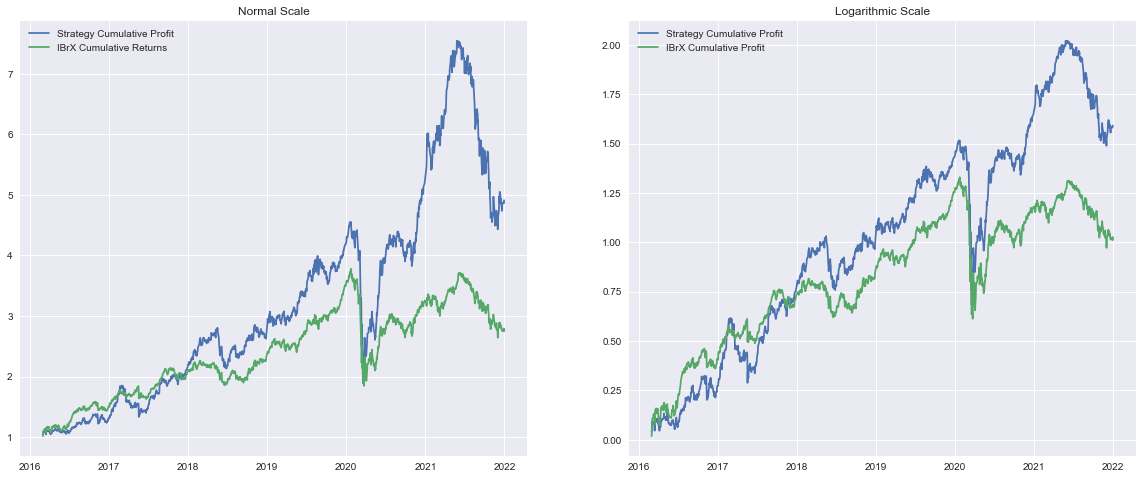

In [93]:
strategy.PlotStrategyResults()

The skewness of the returns observed is: -1.27
The kurtosis of the returns observed is: 16.27


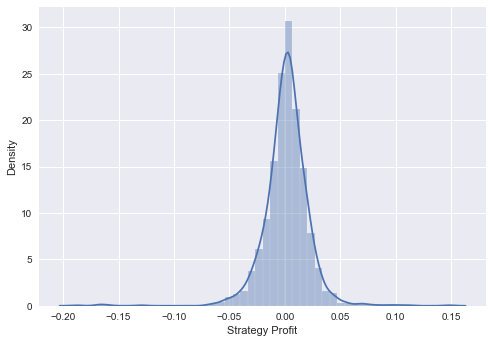

In [94]:
strategy.Returns()

#### Daily Returns and Backtesting

In [95]:
ibrx = strategy.ibrx_calculator()['IBrX Returns']

#### Analysis

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2016-02-29  2016-02-29
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             7.0%        7.0%
Time in Market             100.0%      100.0%

Cumulative Return          413.68%     228.84%
CAGR﹪                     32.35%      22.62%

Sharpe                     0.82        0.66
Prob. Sharpe Ratio         41.9%       30.6%
Smart Sharpe               0.76        0.6
Sortino                    1.12        0.88
Smart Sortino              1.03        0.8
Sortino/√2                 0.8         0.62
Smart Sortino/√2           0.73        0.57
Omega                      1.17        1.17

Max Drawdown               -56.5%      -50.4%
Longest DD Days            230         444
Volatility (ann.)          33.18%      26.95%
R^2                        0.77        0.77
Information Ratio          0.04        0.04
Calmar                     0.57        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-21,2020-03-18,2020-09-01,224,-56.502479,-52.100748
2,2021-05-28,2021-12-01,2021-12-30,216,-40.096413,-39.199592
3,2017-03-02,2017-05-18,2017-08-24,175,-28.030213,-24.515997
4,2018-05-17,2018-06-27,2019-01-02,230,-23.910830,-23.487671
5,2020-09-02,2020-10-30,2020-11-19,78,-12.145928,-10.383492


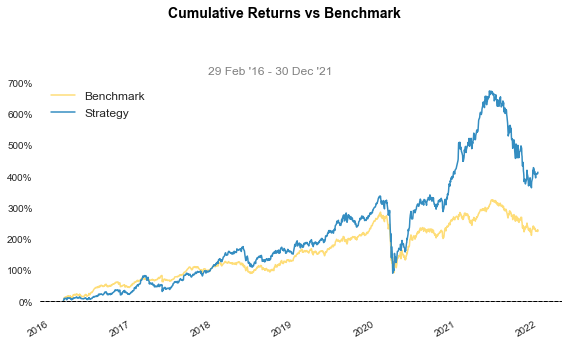

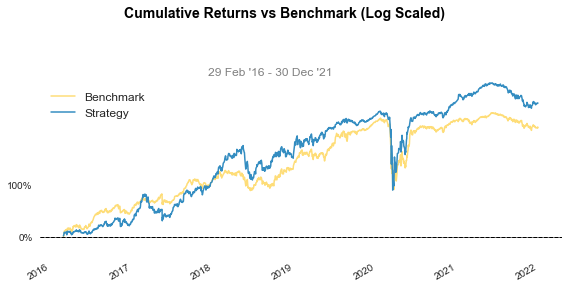

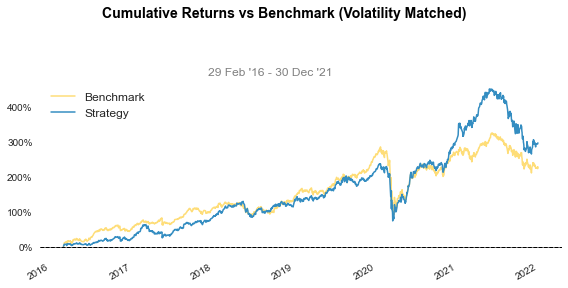

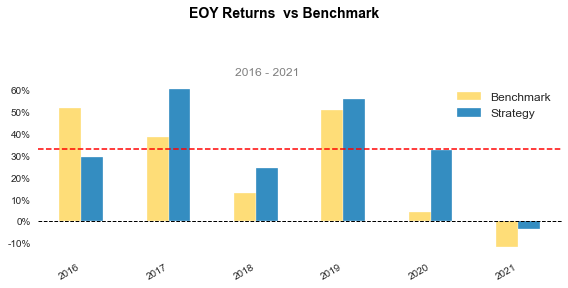

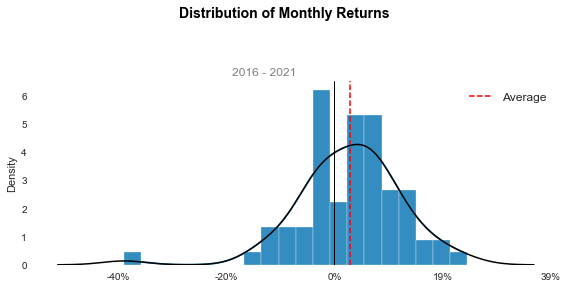

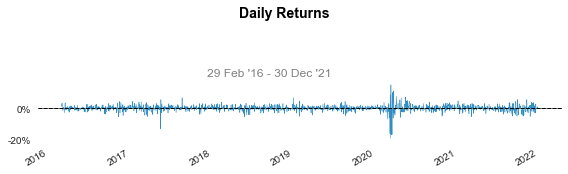

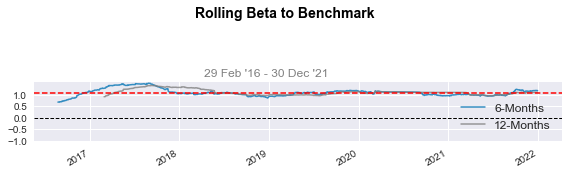

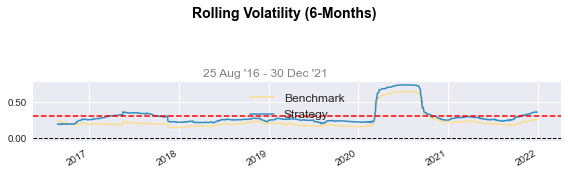

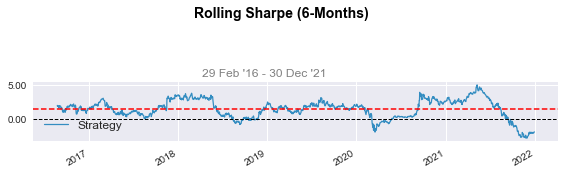

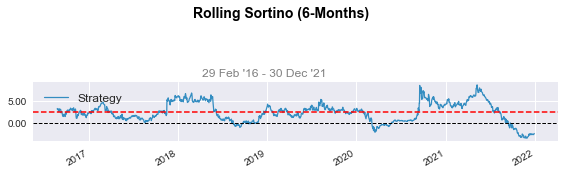

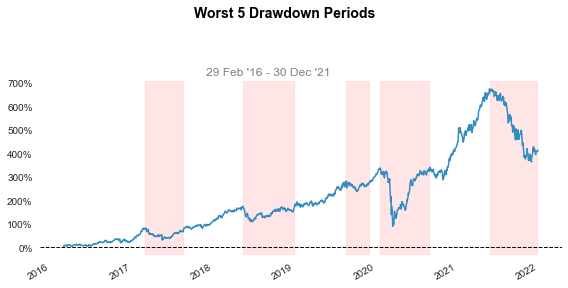

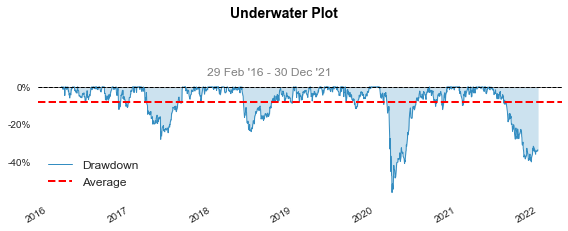

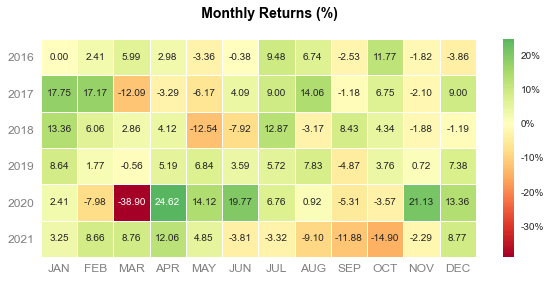

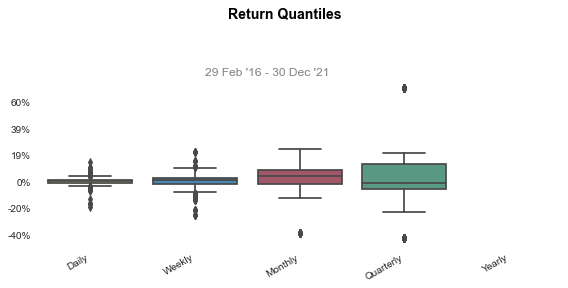

In [96]:
qs.reports.full(back_test['Strategy Profit'],ibrx, rf = 0.07)

In [97]:
sharpe = back_test['Strategy Profit'].mean()/back_test['Strategy Profit'].std()*252**0.5
alfa_spread = (back_test['Strategy Profit'] - back_test['IBrX Returns'])